In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,classification_report

warnings.filterwarnings('ignore')

In [7]:
features = pd.read_csv('spx_cons_norm.csv')
features = features[['tic','datadate','industry_id','multi_class','ROE','Asset Turnover','MA12','Size','PB','ev_ebitda','ROA','PriceCap', 'MA6','earningsVol','PS','dividend_yield']]
# industry_dummy = pd.get_dummies(features['industry_id'])
# features = pd.merge(features,industry_dummy,how='left',left_index=True,right_index=True)

features = features.dropna(subset=['multi_class'])
features_after = features.groupby(['tic']).ffill()
features_after = pd.merge(features_after,features[['tic']],how='left',left_index=True,right_index=True)

cols = [col for col in features_after.columns if col not in ['datadate','industry_id','forward_excess_ret','tic']]
df_na = features_after.isnull()

df_mean = features_after.groupby('tic').mean()

for col in cols:
    na_series = features_after[col].isnull()
    names = list(features_after.loc[na_series,'tic'])     

    t = df_mean.loc[names,col]
    t.index = features_after.loc[na_series,col].index

    
    features_after.loc[na_series,col] = t

for col in cols:
    na_series = features_after[col].isnull()
    mean = np.mean(features_after[col]) 
    features_after.loc[na_series,col] = mean

In [5]:
features_after.columns

Index(['datadate', 'industry_id', 'multi_class', 'ROE', 'Asset Turnover',
       'MA12', 'Size', 'PB', 'ev_ebitda', 'tic'],
      dtype='object')

In [9]:
X = features_after[['ROE','Asset Turnover','MA12','Size','PB','ev_ebitda']]
X_c = features_after[['ROA','PriceCap', 'MA6','earningsVol','PS','dividend_yield']]
#X = sm.add_constant(X)
Y = features_after[['multi_class']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=52)
X_train_c, X_test_c, y_train, y_test = train_test_split(X_c, Y, test_size=0.3, random_state=52)

# Logistic

In [33]:
reg = LogisticRegression(C=0.00013,multi_class='multinomial',penalty='l2',fit_intercept=False)
reg.fit(X_train,y_train)
logistic_predict=reg.predict(X_test)

In [56]:
logistic_df = pd.DataFrame(columns = [0,1,2,3,4,5,6,7,8,9],index = [0,1,2,3,4,5,6,7,8,9])
logistic_df = logistic_df.replace(np.nan,0)
for i in range(len(y_test)):
    logistic_df.loc[np.array(y_test)[i],logistic_predict[i]] += 1
logistic_df

,0,1,2,3,4,5,6,7,8,9
0,490,13,35,82,397,132,20,0,27,574
1,391,17,30,95,514,128,13,0,37,523
2,393,15,40,95,551,116,16,0,34,537
3,335,6,35,77,577,133,19,0,29,519
4,332,16,37,86,552,139,15,0,24,503
5,315,13,33,74,557,139,9,0,44,513
6,335,11,36,73,550,151,13,0,40,549
7,338,12,26,86,583,129,18,1,43,520
8,386,8,33,87,520,137,22,0,40,533
9,473,8,29,57,402,141,15,0,43,563


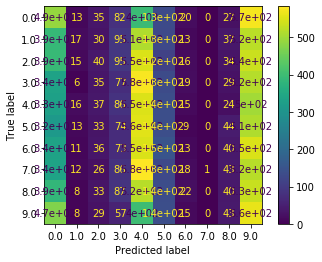

In [41]:
plot_confusion_matrix(reg,X_test,y_test)

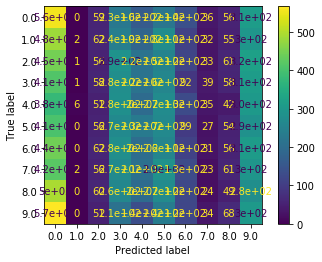

In [11]:
reg_c = LogisticRegression(C=0.00013,multi_class='multinomial',penalty='l2',fit_intercept=False)
reg_c.fit(X_train_c,y_train)
logistic_predict_c=reg_c.predict(X_test_c)
plot_confusion_matrix(reg_c,X_test_c,y_test)

# KNN

In [64]:
neigh = KNeighborsClassifier(n_neighbors=900)
knn_predict = neigh.fit(X_train,y_train).predict(X_test)

In [69]:
knn_df = pd.DataFrame(columns = [0,1,2,3,4,5,6,7,8,9],index = [0,1,2,3,4,5,6,7,8,9])
knn_df = knn_df.replace(np.nan,0)
for i in range(len(y_test)):
    knn_df.loc[np.array(y_test)[i],knn_predict[i]] += 1
knn_df

,0,1,2,3,4,5,6,7,8,9
0,335,110,67,140,294,180,108,127,96,313
1,215,122,68,151,350,247,107,146,81,261
2,219,109,88,148,360,268,104,171,94,236
3,196,89,65,197,374,268,108,133,98,202
4,150,102,83,169,394,247,113,164,82,200
5,175,97,73,142,350,286,130,169,88,187
6,192,86,67,174,360,288,140,143,88,220
7,191,91,79,169,363,269,125,155,99,215
8,234,85,65,169,383,241,126,135,87,241
9,353,103,71,116,292,163,118,115,83,317


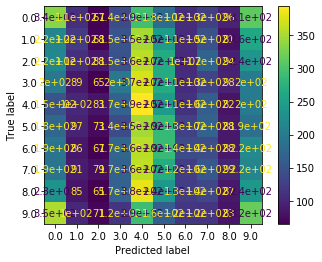

In [66]:
plot_confusion_matrix(neigh,X_test,y_test)

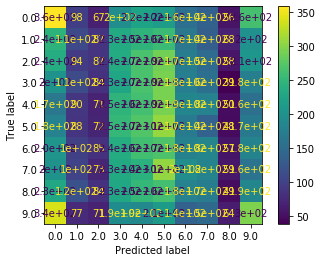

In [13]:
neigh_c = KNeighborsClassifier(n_neighbors=900)
knn_predict_c = neigh_c.fit(X_train_c,y_train).predict(X_test_c)
plot_confusion_matrix(neigh_c,X_test_c,y_test)

# random forest

In [73]:
regr = RandomForestClassifier(max_depth=10, random_state=0)
fm_predict = regr.fit(X_train,y_train).predict(X_test)

In [74]:
rm_df = pd.DataFrame(columns = [0,1,2,3,4,5,6,7,8,9],index = [0,1,2,3,4,5,6,7,8,9])
rm_df = rm_df.replace(np.nan,0)
for i in range(len(y_test)):
    rm_df.loc[np.array(y_test)[i],fm_predict[i]] += 1
rm_df

,0,1,2,3,4,5,6,7,8,9
0,373,82,60,95,332,178,79,66,77,428
1,209,97,57,120,447,197,95,84,79,363
2,204,68,51,131,460,243,123,91,82,344
3,189,65,45,125,485,226,116,85,88,306
4,143,86,53,125,493,241,113,96,76,278
5,161,84,39,117,467,267,97,92,66,307
6,184,85,47,119,480,248,109,90,79,317
7,175,79,52,120,493,249,118,88,70,312
8,225,65,32,119,477,225,117,89,66,351
9,320,73,55,91,323,149,73,83,91,473


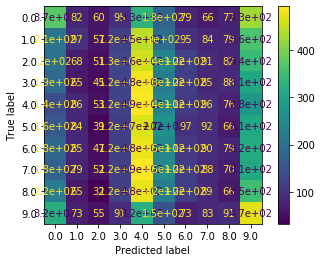

In [75]:
plot_confusion_matrix(regr,X_test,y_test)

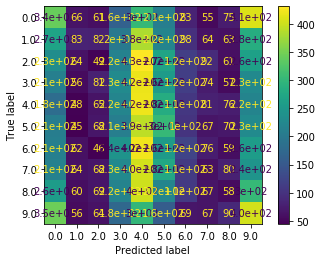

In [14]:
regr_c= RandomForestClassifier(max_depth=10, random_state=0)
fm_predict_c = regr_c.fit(X_train_c,y_train).predict(X_test_c)
plot_confusion_matrix(regr_c,X_test_c,y_test)